In [1]:
from   joblib import dump
import numpy as np
import pandas as pd
import random
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.metrics import accuracy_score, roc_auc_score
from   src.feature_importance import extract_feature_importance, plot_feature_importance, rank_feature_importance
from   src.feature_selection import remove_correlated_features
from   src.model_evaluation import adjusted_prediction, eval_sensitivity_specificity

## Settings

In [2]:
# Set feature files (contains patient info and pyradiomics features)
feature_file_training_set = 'extracted_radiomics_features/extracted_example_features_train.csv' # RVC dataset
label_file_training_set   = 'data/example_labels_train.csv'

# Number of thresholds
n_thresholds = 401

# Meta info header columns
n_header_cols = 22

# Feature selection
corr_threshold    = 0.8

# Fix seed
seed = 42
np.random.seed(seed)
random.seed(seed)

## Data

In [3]:
# Load pyradiomics features and labels
df_features_training = pd.read_csv(feature_file_training_set)
labels_training      = np.loadtxt(label_file_training_set)

In [4]:
# Inspect feature file
df_features_training

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},4d22955ee79b24bc744a8bad21195feda217d228,3D,"(1.0, 1.0, 1.0)",...,8438.540262,0.010331,7.366261,0.949246,0.059280,0.019727,0.004660,440566.527274,6.871414,47.854486
1,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},146aa3517683f2ad362e10fc3c2b7ffc2cc19f93,3D,"(1.0, 1.0, 1.0)",...,8164.669110,0.009941,7.371531,0.935528,0.072963,0.019765,0.004604,437926.914601,6.528345,47.359422
2,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7969a8186618f072ad39980d13192cf134005c81,3D,"(1.0, 1.0, 1.0)",...,9070.722630,0.007485,7.396664,0.934156,0.071390,0.018642,0.004304,467492.600158,7.125012,48.434773
3,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},40a2e9b08312ca4524646d3d355787830f6da9be,3D,"(1.0, 1.0, 1.0)",...,8511.088221,0.009914,7.395036,0.935528,0.072963,0.019946,0.004454,445117.530692,7.227345,47.024958
4,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},aea3c45fcd3fa2c3a84b801e3ecf8f8504ed5ae6,3D,"(1.0, 1.0, 1.0)",...,8514.572907,0.012318,7.350737,0.946502,0.067820,0.019127,0.004621,442918.835492,6.525662,48.885326
5,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7aaefab3873b1d9c1a61c977428f492a0c0d738e,3D,"(1.0, 1.0, 1.0)",...,9116.926060,0.005309,7.385063,0.945130,0.060490,0.018740,0.004590,450771.399001,6.973380,48.189647
6,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},06e1308cf71565cdcbd1c1cb8d70ef48e91904fd,3D,"(1.0, 1.0, 1.0)",...,8497.367799,0.009018,7.439163,0.928669,0.085681,0.018802,0.004634,447927.445612,6.894316,49.523209
7,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},0fa3d174dd4a3ef39e91d51f59acafded8b6a15d,3D,"(1.0, 1.0, 1.0)",...,8570.180525,0.009329,7.356454,0.936900,0.089168,0.018733,0.004744,421801.433828,6.260574,48.935080
8,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},082e4889ac3384ad9f51d02fa839b3127175ab5a,3D,"(1.0, 1.0, 1.0)",...,8326.420083,0.006253,7.403529,0.939643,0.074706,0.020737,0.004495,444830.333652,7.393673,46.569711
9,2.2.0,1.17.4,1.2.4,1.1.1,3.7.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},0c86569ebfb1e671b9afaf672eeb9149acbb8b15,3D,"(1.0, 1.0, 1.0)",...,8992.644274,0.012530,7.403597,0.941015,0.067500,0.019668,0.004228,479119.579990,7.758806,46.702033


In [5]:
# Drop meta info header columns
df_features_training.drop(columns = df_features_training.columns[:n_header_cols], inplace=True)
df_features_training

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8438.540262,0.010331,7.366261,0.949246,0.059280,0.019727,0.004660,440566.527274,6.871414,47.854486
1,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8164.669110,0.009941,7.371531,0.935528,0.072963,0.019765,0.004604,437926.914601,6.528345,47.359422
2,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,9070.722630,0.007485,7.396664,0.934156,0.071390,0.018642,0.004304,467492.600158,7.125012,48.434773
3,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8511.088221,0.009914,7.395036,0.935528,0.072963,0.019946,0.004454,445117.530692,7.227345,47.024958
4,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8514.572907,0.012318,7.350737,0.946502,0.067820,0.019127,0.004621,442918.835492,6.525662,48.885326
5,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,9116.926060,0.005309,7.385063,0.945130,0.060490,0.018740,0.004590,450771.399001,6.973380,48.189647
6,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8497.367799,0.009018,7.439163,0.928669,0.085681,0.018802,0.004634,447927.445612,6.894316,49.523209
7,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8570.180525,0.009329,7.356454,0.936900,0.089168,0.018733,0.004744,421801.433828,6.260574,48.935080
8,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8326.420083,0.006253,7.403529,0.939643,0.074706,0.020737,0.004495,444830.333652,7.393673,46.569711
9,1.0,1.0,10.327956,10.327956,12.041595,12.041595,12.041595,14.456832,716.166667,10.327956,...,8992.644274,0.012530,7.403597,0.941015,0.067500,0.019668,0.004228,479119.579990,7.758806,46.702033


In [6]:
# Inspect labels
labels_training

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 1.])

## Feature selection

Of the features previously extracted, features highly correlated with another feature are identified and excluded from the analysis. This feature selection based on pair-wise feature correlation is applied to improve the machine learning training process and to enable optimized feature interpretability. For this purpose, we calculate a Pearson correlation matrix for all features extracted from the training set and exclude one feature of any feature pair with a Person correlation coefficient above 'corr_threshold'.

In [7]:
# Identify and remove strongly correlated features in the training dataset
df_features_training_uncorr, dropped_features = remove_correlated_features(df_features_training, corr_threshold=corr_threshold)

# Save names of features which have been dropped and will not be used for training or evaluating the random forest model
dropped_features = np.asarray(dropped_features)
np.savetxt('feature_selection/dropped_features.csv', dropped_features, newline=',', fmt='%s')

# Save names of features which have been selected and will be used for training and evaluating the random forest model
feature_names = df_features_training_uncorr.columns.to_numpy()
np.savetxt('feature_selection/selected_features.csv', feature_names, newline=',', fmt='%s')
print("Number of remaining features:", len(feature_names))

Remove correlated features...
Correlation threshold: 0.8
Drop 73 / 107  features ( 68.2 %).
Number of remaining features: 34


## Random forest training

In [8]:
# Prepare the training data, i.e. select the feature columns and the label column, respectively, and ignore the rest.
X_train = df_features_training_uncorr.to_numpy()
y_train = labels_training

# Set up the random forest model
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0)

# Train the model
rf.fit(X_train, y_train)

# Save model
dump(rf, 'trained_models/trained_example_random_forest_model.joblib')

['trained_models/trained_example_random_forest_model.joblib']

## Internal validation (using out-of-bag predictions)

We use the out-of-bag (OOB) predictions to get a point estimate of the performance that can be expected from the model for unseen data. In addition, we evaluate the out-of-bag predictions for a wide range of classification thresholds in order to pick and report three different models (A, B and C) later on (see below).

In [9]:
# Set up a wide range of classification thresholds
thresholds = np.linspace(0.0,1.0,n_thresholds)

In [10]:
# Internal evaluation
oob_bin_acc     = []
oob_sensitivity = []
oob_specificity = []

oob_roc_auc = roc_auc_score(y_train, rf.oob_decision_function_[:, 1])

# Apply different thresholds for classification
for t in thresholds:

    # Adjust out-of-bag prediction for the current threshold
    y_pred_adj = adjusted_prediction(rf.oob_decision_function_, threshold=t, positive_label=1)

    # Out-of-bag prediction scores for the current threshold
    bin_acc_thr = accuracy_score(y_train, y_pred_adj)
    roc_auc_thr = roc_auc_score(y_train, rf.oob_decision_function_[:, 1])
    sensitivity_thr, specificity_thr = eval_sensitivity_specificity(y_train, y_pred_adj)

    oob_bin_acc.append(bin_acc_thr)
    oob_sensitivity.append(sensitivity_thr)
    oob_specificity.append(specificity_thr)

oob_bin_acc     = np.asarray(oob_bin_acc)
oob_sensitivity = np.asarray(oob_sensitivity)
oob_specificity = np.asarray(oob_specificity)

## Search classification thresholds

Sensitivity and specificity depend on the classification threshold, a parameter which is used to turn predicted class probabilities, i.e. the output of the random forest model (here: rf.oob_decision_function_) for a given input sample, into class predictions (benign versus premalignant).

Here, we search for three different thresholds:
1. A default threshold value of 0.5 (Model A)
2. A threshold value which maximizes Youden's index (J=sensitivity+specificity+1) (Model B)
3. A threshold that results in the highest possible specificity while achieving a sensitivity of at least 0.85 (Model C)

In [11]:
# Find default threshold of 0.5
ind_thr_50 = int(len(thresholds)/2.0)

# Find threshold which maximizes Youden's index J
J         = oob_sensitivity + oob_specificity - 1
J_max     = np.amax(J)
ind_J_max = np.argmax(J)
print("Maximum Youden's index J = {:0.2f} found for threshold T = {:0.4f}".format(J_max, thresholds[ind_J_max]))

# Find threshold which yields sensitivity of 0.85
ind_85 = 0
while(oob_sensitivity[ind_85] >= 0.85):
    ind_85 += 1

Maximum Youden's index J = 0.00 found for threshold T = 0.0000


In [12]:
print("Internal out-of-bag (OOB) validation:\n")
print('oob_roc_auc: {:.2f}'.format(oob_roc_auc))

print("\nOOB scores for threshold of {:0.1f} (Model A):\n".format(thresholds[ind_thr_50]))  
print('bin_acc:     {:0.2f}'.format(oob_bin_acc[ind_thr_50]))
print('sensitivity: {:0.2f}'.format(oob_sensitivity[ind_thr_50]))
print('specifity:   {:0.2f}'.format(oob_specificity[ind_thr_50]))

print("\nOOB scores for a maximized Youden's Index (Model B, threshold = {:0.3f}):\n".format(thresholds[ind_J_max]))  
print('bin_acc:     {:0.2f}'.format(oob_bin_acc[ind_J_max]))
print('sensitivity: {:0.2f}'.format(oob_sensitivity[ind_J_max]))
print('specifity:   {:0.2f}'.format(oob_specificity[ind_J_max]))

print("\nOOB scores for a sensitivity of 0.85 (Model C, threshold = {:0.3f}):\n".format(thresholds[ind_85]))  
print('bin_acc:     {:0.2f}'.format(oob_bin_acc[ind_85]))
print('sensitivity: {:0.2f}'.format(oob_sensitivity[ind_85]))
print('specifity:   {:0.2f}'.format(oob_specificity[ind_85]))

Internal out-of-bag (OOB) validation:

oob_roc_auc: 0.23

OOB scores for threshold of 0.5 (Model A):

bin_acc:     0.36
sensitivity: 0.00
specifity:   0.64

OOB scores for a maximized Youden's Index (Model B, threshold = 0.000):

bin_acc:     0.44
sensitivity: 1.00
specifity:   0.00

OOB scores for a sensitivity of 0.85 (Model C, threshold = 0.233):

bin_acc:     0.36
sensitivity: 0.82
specifity:   0.00


## Feature importance

The Scikit-learn random forest implementation provides an internal estimate of feature importance, i.e. how much the class prediction (benign versus premalignant) of a trained model depends on a specific feature relative to all other features. Here, we evaluate the relative importance of the features used for training the random forest.

 1. feature  15: original_firstorder_90Percentile (0.096223)
 2. feature  17: original_firstorder_Entropy (0.065844)
 3. feature  14: original_firstorder_10Percentile (0.064274)
 4. feature  24: original_glcm_InverseVariance (0.060633)
 5. feature  23: original_glcm_Id (0.055962)
 6. feature  22: original_glcm_Correlation (0.055184)
 7. feature  19: original_firstorder_Maximum (0.054201)
 8. feature  28: original_gldm_DependenceEntropy (0.051140)
 9. feature  20: original_firstorder_Minimum (0.049560)
10. feature  26: original_glcm_MCC (0.048734)


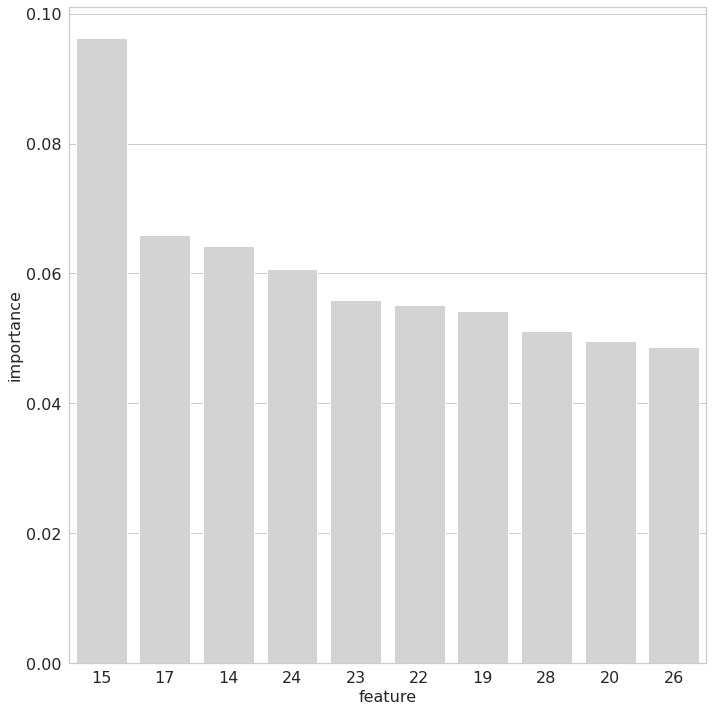

In [13]:
# Get feature importance from random forest model
importances, _ = extract_feature_importance(rf)

# Rank features according to their importance
ranked_features_id, ranked_features_name, ranked_importances = rank_feature_importance(importances, feature_names, n=10)

# Plot feature importance
plot_feature_importance(ranked_features_id, ranked_importances)